In [1]:
using DiffEqJump, StochasticDiffEq, DiffEqCallbacks
using StatsBase, Parameters, Plots, Distributions

In [27]:
# functional parameters 
function affect!(integrator) # jump process
      n = rand(1:integrator.p.N)
      n2 = rand(1:integrator.p.N)
      integrator.u[n] = max(integrator.u[n], integrator.u[n2])
end
function drift(du,u,p,t) # constant drift
      du .= p.μ
end
function volatility(du,u,p,t) # constant shock exposure
      du .= p.σ
end
rate(u,p,t) = p.β*p.N # jump rate


# main params bundle
params = @with_kw (
    μ = 0.01, # mean
    σ = 0.1, # drift
    N = 10, # num particles
    β = 0.2, # rate parameter
    t = 0.:0.01:1000., # time steps to save
    moments = Array{Array{Float64, 1}, 1}(), # container for moments
    α = 2.0, # shape parameter for the initial condition distribution
    iv_dist = Exponential(1/α), # updates based on supplied α
    trajectories = 2, # number of members for ensemble methods 
    jump_algorithm = SRIW1(), # jump diffeq algorithm
    drift = drift, 
    volatility = volatility, 
    affect! = affect!, # jump process 
    rate = rate)

#51 (generic function with 2 methods)

In [28]:
function generate_jump_prob(p)
    function calculate_moments(u, t, integrator) 
        g = (length(integrator.p.moments) == 0. ? 0. : (mean(u) - integrator.p.moments[end][2])/step(integrator.p.t))
        moments = [minimum(u), mean(u), maximum(u), g]
        push!(integrator.p.moments, moments) 
    end
    cb = FunctionCallingCallback(calculate_moments; funcat=p.t, func_everystep=false, func_start = true, tdir=1);
    x_iv = rand(p.iv_dist, p.N) # draw initial condition
    sde_prob = SDEProblem(p.drift, p.volatility, x_iv, (0.0, p.t[end]), p)
    jump = ConstantRateJump(rate, p.affect!)
    jump_prob = JumpProblem(sde_prob, Direct(), jump)
    return jump_prob, cb
end

p = params();

### First Run

In [29]:
jump_prob, cb = generate_jump_prob(p)
sol = solve(jump_prob, p.jump_algorithm, saveat = p.t, callback = cb)
gs = [timepoint[4] for timepoint in p.moments]
summarystats(gs)

Summary Stats:
Length:         100001
Missing Count:  0
Mean:           0.050086
Minimum:        -0.902692
1st Quartile:   -0.055244
Median:         0.009705
3rd Quartile:   0.078247
Maximum:        24.978151


For the histogram, let's eliminate "outliers."

# of observations dropped: 771


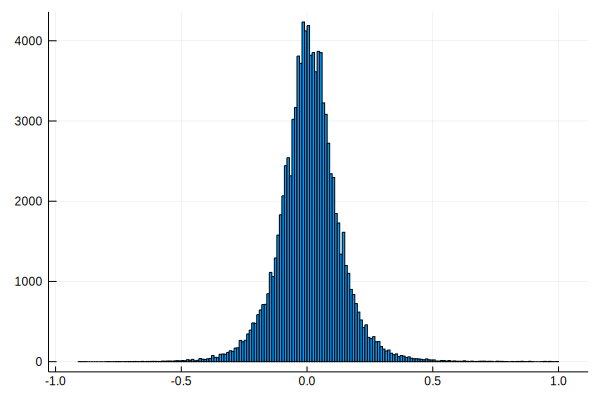

In [30]:
gs_clamped = filter(x -> x < 1 && x > -1, gs)
println("# of observations dropped: $(length(gs) - length(gs_clamped))") # distributions dropped
histogram(gs_clamped, legend = false)

### Second Run, New Initial Condition Draw

In [31]:
p = params()
jump_prob, cb = generate_jump_prob(p)
sol = solve(jump_prob, p.jump_algorithm, saveat = p.t, callback = cb)
gs = [timepoint[4] for timepoint in p.moments]
summarystats(gs)

Summary Stats:
Length:         100001
Missing Count:  0
Mean:           0.051289
Minimum:        -1.110053
1st Quartile:   -0.055965
Median:         0.012785
3rd Quartile:   0.081049
Maximum:        24.458345


# of observations dropped: 767


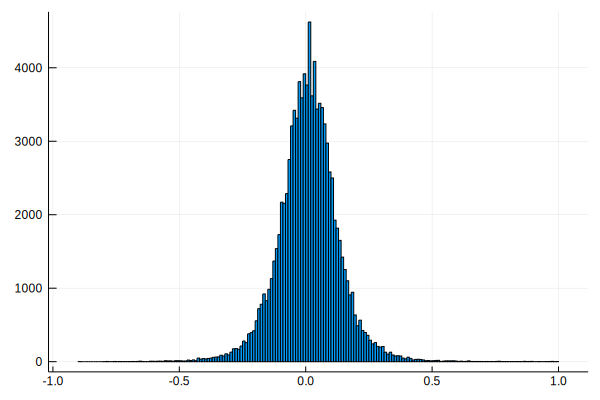

In [33]:
gs_clamped = filter(x -> x < 1 && x > -1, gs)
println("# of observations dropped: $(length(gs) - length(gs_clamped))") # distributions dropped
histogram(gs_clamped, legend = false)